In [1]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

9913344it [00:01, 8180954.47it/s]                             


Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw


29696it [00:00, 29754909.60it/s]         

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw


1649664it [00:00, 7801107.52it/s]                             


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw


5120it [00:00, ?it/s]                   
D:\anaconda\envs\py38\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw
Processing...
Done!


In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [4]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [15]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 2

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
    (linear3): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [16]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [17]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [18]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 67938.421875
	 partial train loss (single batch): 66373.492188
	 partial train loss (single batch): 65386.421875
	 partial train loss (single batch): 64147.972656
	 partial train loss (single batch): 63478.082031
	 partial train loss (single batch): 62577.558594
	 partial train loss (single batch): 61801.074219
	 partial train loss (single batch): 61462.093750
	 partial train loss (single batch): 60598.531250
	 partial train loss (single batch): 60200.792969
	 partial train loss (single batch): 59504.886719
	 partial train loss (single batch): 59374.171875
	 partial train loss (single batch): 58803.289062
	 partial train loss (single batch): 58159.957031
	 partial train loss (single batch): 57967.289062
	 partial train loss (single batch): 57524.378906
	 partial train loss (single batch): 57444.238281
	 partial train loss (single batch): 56938.378906
	 partial train loss (single batch): 56613.082031
	 partial train loss (single batch): 56098.097656


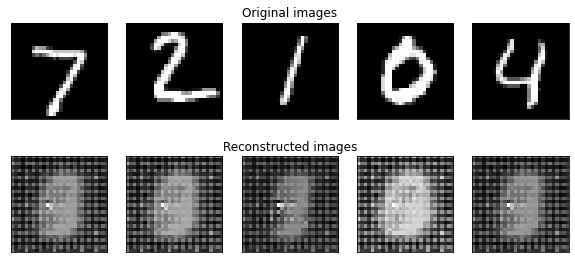

	 partial train loss (single batch): 22195.847656
	 partial train loss (single batch): 22013.099609
	 partial train loss (single batch): 21865.632812
	 partial train loss (single batch): 22008.031250
	 partial train loss (single batch): 21827.187500
	 partial train loss (single batch): 21813.693359
	 partial train loss (single batch): 21740.828125
	 partial train loss (single batch): 21473.498047
	 partial train loss (single batch): 21532.748047
	 partial train loss (single batch): 21503.376953
	 partial train loss (single batch): 21413.619141
	 partial train loss (single batch): 21021.472656
	 partial train loss (single batch): 21131.978516
	 partial train loss (single batch): 21198.449219
	 partial train loss (single batch): 20894.527344
	 partial train loss (single batch): 21092.353516
	 partial train loss (single batch): 20749.404297
	 partial train loss (single batch): 20890.453125
	 partial train loss (single batch): 20573.066406
	 partial train loss (single batch): 20535.275391


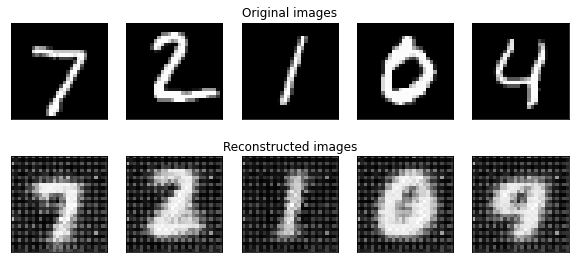

	 partial train loss (single batch): 13736.345703
	 partial train loss (single batch): 13760.080078
	 partial train loss (single batch): 13748.726562
	 partial train loss (single batch): 13939.068359
	 partial train loss (single batch): 14006.810547
	 partial train loss (single batch): 13959.224609
	 partial train loss (single batch): 13975.050781
	 partial train loss (single batch): 13795.070312
	 partial train loss (single batch): 13898.529297
	 partial train loss (single batch): 13870.509766
	 partial train loss (single batch): 14028.978516
	 partial train loss (single batch): 13452.947266
	 partial train loss (single batch): 13734.865234
	 partial train loss (single batch): 14084.861328
	 partial train loss (single batch): 13641.986328
	 partial train loss (single batch): 13933.279297
	 partial train loss (single batch): 13373.480469
	 partial train loss (single batch): 13750.610352
	 partial train loss (single batch): 13486.532227
	 partial train loss (single batch): 13661.956055


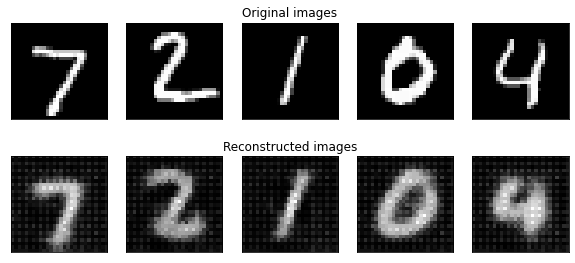

	 partial train loss (single batch): 11540.807617
	 partial train loss (single batch): 11724.627930
	 partial train loss (single batch): 11764.948242
	 partial train loss (single batch): 12068.247070
	 partial train loss (single batch): 11953.789062
	 partial train loss (single batch): 11711.094727
	 partial train loss (single batch): 11876.789062
	 partial train loss (single batch): 11962.379883
	 partial train loss (single batch): 11981.625000
	 partial train loss (single batch): 11820.223633
	 partial train loss (single batch): 12187.385742
	 partial train loss (single batch): 11519.204102
	 partial train loss (single batch): 11872.911133
	 partial train loss (single batch): 12235.472656
	 partial train loss (single batch): 11706.627930
	 partial train loss (single batch): 12020.506836
	 partial train loss (single batch): 11612.423828
	 partial train loss (single batch): 11925.328125
	 partial train loss (single batch): 11618.829102
	 partial train loss (single batch): 11668.677734


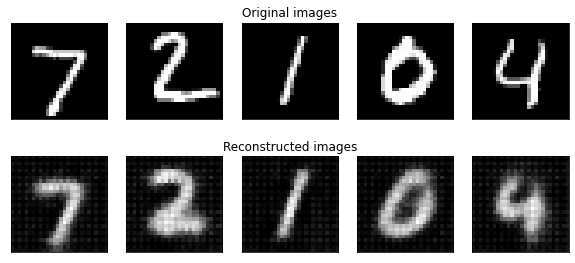

	 partial train loss (single batch): 10721.008789
	 partial train loss (single batch): 10856.296875
	 partial train loss (single batch): 10758.439453
	 partial train loss (single batch): 11266.914062
	 partial train loss (single batch): 11049.185547
	 partial train loss (single batch): 10697.535156
	 partial train loss (single batch): 10966.434570
	 partial train loss (single batch): 11239.740234
	 partial train loss (single batch): 11296.823242
	 partial train loss (single batch): 10950.698242
	 partial train loss (single batch): 11279.107422
	 partial train loss (single batch): 10683.770508
	 partial train loss (single batch): 11078.048828
	 partial train loss (single batch): 11554.663086
	 partial train loss (single batch): 10835.074219
	 partial train loss (single batch): 11159.001953
	 partial train loss (single batch): 10717.696289
	 partial train loss (single batch): 11058.739258
	 partial train loss (single batch): 10821.857422
	 partial train loss (single batch): 10805.391602


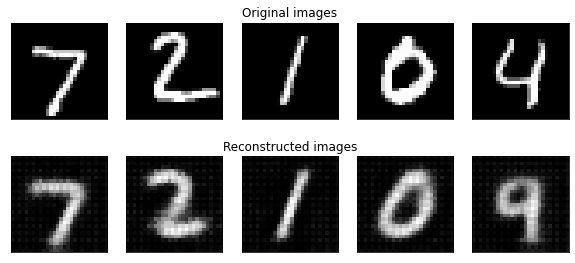

	 partial train loss (single batch): 10154.898438
	 partial train loss (single batch): 10238.374023
	 partial train loss (single batch): 10211.950195
	 partial train loss (single batch): 10603.436523
	 partial train loss (single batch): 10452.372070
	 partial train loss (single batch): 10176.666016
	 partial train loss (single batch): 10447.097656
	 partial train loss (single batch): 10867.708984
	 partial train loss (single batch): 10838.308594
	 partial train loss (single batch): 10514.792969
	 partial train loss (single batch): 10865.207031
	 partial train loss (single batch): 10185.423828
	 partial train loss (single batch): 10677.859375
	 partial train loss (single batch): 11067.818359
	 partial train loss (single batch): 10301.185547
	 partial train loss (single batch): 10600.648438
	 partial train loss (single batch): 10145.375000
	 partial train loss (single batch): 10602.812500
	 partial train loss (single batch): 10342.763672
	 partial train loss (single batch): 10354.123047


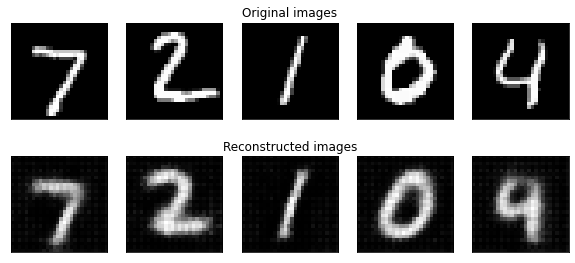

	 partial train loss (single batch): 9889.967773
	 partial train loss (single batch): 9954.181641
	 partial train loss (single batch): 9890.760742
	 partial train loss (single batch): 10390.705078
	 partial train loss (single batch): 10251.067383
	 partial train loss (single batch): 9962.542969
	 partial train loss (single batch): 10101.969727
	 partial train loss (single batch): 10522.411133
	 partial train loss (single batch): 10490.601562
	 partial train loss (single batch): 10256.096680
	 partial train loss (single batch): 10519.695312
	 partial train loss (single batch): 9942.193359
	 partial train loss (single batch): 10400.430664
	 partial train loss (single batch): 10749.537109
	 partial train loss (single batch): 10108.556641
	 partial train loss (single batch): 10313.211914
	 partial train loss (single batch): 9941.377930
	 partial train loss (single batch): 10308.101562
	 partial train loss (single batch): 10081.286133
	 partial train loss (single batch): 10092.576172
	 part

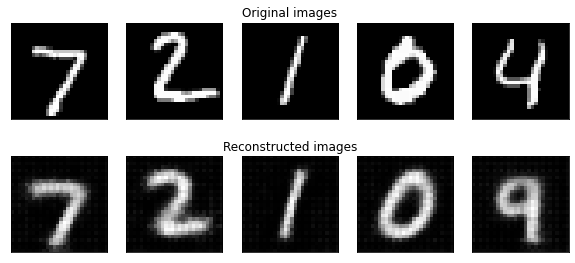

	 partial train loss (single batch): 9691.659180
	 partial train loss (single batch): 9938.842773
	 partial train loss (single batch): 9864.138672
	 partial train loss (single batch): 10309.140625
	 partial train loss (single batch): 10071.914062
	 partial train loss (single batch): 9834.158203
	 partial train loss (single batch): 9875.470703
	 partial train loss (single batch): 10393.076172
	 partial train loss (single batch): 10425.864258
	 partial train loss (single batch): 10113.986328
	 partial train loss (single batch): 10447.083008
	 partial train loss (single batch): 9824.738281
	 partial train loss (single batch): 10250.359375
	 partial train loss (single batch): 10550.789062
	 partial train loss (single batch): 9969.621094
	 partial train loss (single batch): 10234.313477
	 partial train loss (single batch): 9747.644531
	 partial train loss (single batch): 10117.080078
	 partial train loss (single batch): 9937.660156
	 partial train loss (single batch): 9957.097656
	 partial 

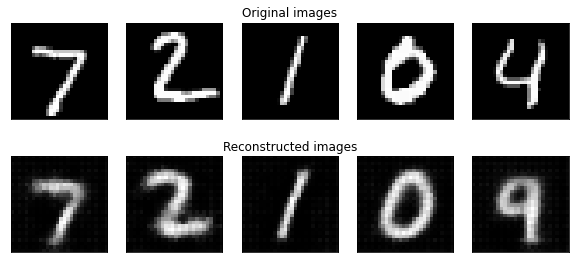

	 partial train loss (single batch): 9612.300781
	 partial train loss (single batch): 9764.804688
	 partial train loss (single batch): 9698.944336
	 partial train loss (single batch): 10151.577148
	 partial train loss (single batch): 9988.517578
	 partial train loss (single batch): 9751.852539
	 partial train loss (single batch): 9755.017578
	 partial train loss (single batch): 10263.896484
	 partial train loss (single batch): 10294.626953
	 partial train loss (single batch): 10022.175781
	 partial train loss (single batch): 10378.205078
	 partial train loss (single batch): 9709.995117
	 partial train loss (single batch): 10157.653320
	 partial train loss (single batch): 10441.120117
	 partial train loss (single batch): 9784.466797
	 partial train loss (single batch): 10108.791016
	 partial train loss (single batch): 9642.680664
	 partial train loss (single batch): 9937.600586
	 partial train loss (single batch): 9837.352539
	 partial train loss (single batch): 9775.834961
	 partial tr

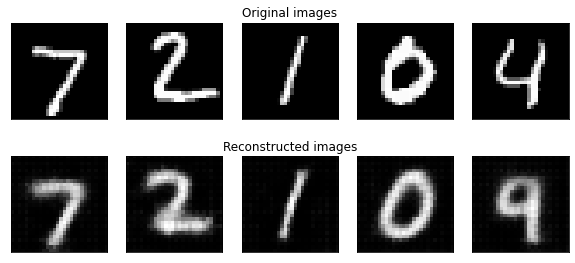

	 partial train loss (single batch): 9463.003906
	 partial train loss (single batch): 9638.064453
	 partial train loss (single batch): 9560.259766
	 partial train loss (single batch): 10031.958984
	 partial train loss (single batch): 9863.860352
	 partial train loss (single batch): 9647.335938
	 partial train loss (single batch): 9678.017578
	 partial train loss (single batch): 10143.302734
	 partial train loss (single batch): 10144.201172
	 partial train loss (single batch): 9914.936523
	 partial train loss (single batch): 10238.152344
	 partial train loss (single batch): 9680.704102
	 partial train loss (single batch): 10155.561523
	 partial train loss (single batch): 10350.197266
	 partial train loss (single batch): 9781.143555
	 partial train loss (single batch): 10000.247070
	 partial train loss (single batch): 9482.956055
	 partial train loss (single batch): 9847.927734
	 partial train loss (single batch): 9775.144531
	 partial train loss (single batch): 9789.399414
	 partial tra

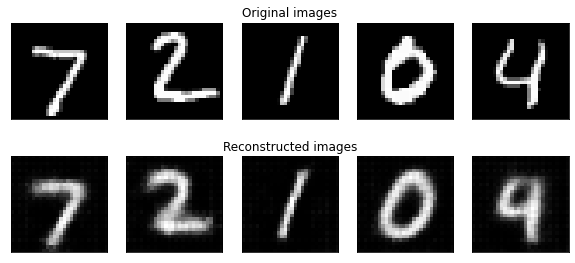

	 partial train loss (single batch): 9386.416992
	 partial train loss (single batch): 9594.840820
	 partial train loss (single batch): 9557.645508
	 partial train loss (single batch): 9915.872070
	 partial train loss (single batch): 9855.096680
	 partial train loss (single batch): 9541.355469
	 partial train loss (single batch): 9563.215820
	 partial train loss (single batch): 10126.344727
	 partial train loss (single batch): 10086.103516
	 partial train loss (single batch): 9811.792969
	 partial train loss (single batch): 10211.722656
	 partial train loss (single batch): 9572.363281
	 partial train loss (single batch): 9988.055664
	 partial train loss (single batch): 10254.435547
	 partial train loss (single batch): 9657.606445
	 partial train loss (single batch): 9864.796875
	 partial train loss (single batch): 9450.118164
	 partial train loss (single batch): 9796.642578
	 partial train loss (single batch): 9711.267578
	 partial train loss (single batch): 9736.731445
	 partial train 

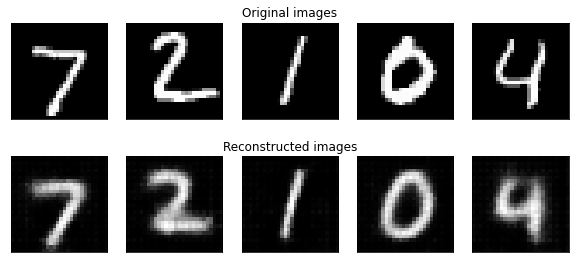

	 partial train loss (single batch): 9324.245117
	 partial train loss (single batch): 9553.776367
	 partial train loss (single batch): 9316.601562
	 partial train loss (single batch): 9781.546875
	 partial train loss (single batch): 9725.582031
	 partial train loss (single batch): 9443.000000
	 partial train loss (single batch): 9523.676758
	 partial train loss (single batch): 9997.194336
	 partial train loss (single batch): 10022.762695
	 partial train loss (single batch): 9770.576172
	 partial train loss (single batch): 10193.732422
	 partial train loss (single batch): 9499.467773
	 partial train loss (single batch): 9966.505859
	 partial train loss (single batch): 10228.826172
	 partial train loss (single batch): 9568.036133
	 partial train loss (single batch): 9829.937500
	 partial train loss (single batch): 9396.383789
	 partial train loss (single batch): 9728.184570
	 partial train loss (single batch): 9575.683594
	 partial train loss (single batch): 9686.645508
	 partial train l

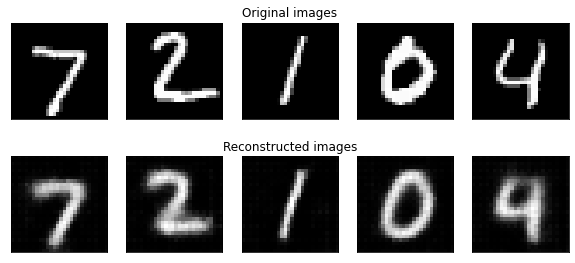

	 partial train loss (single batch): 9254.499023
	 partial train loss (single batch): 9490.156250
	 partial train loss (single batch): 9361.973633
	 partial train loss (single batch): 9823.061523
	 partial train loss (single batch): 9687.486328
	 partial train loss (single batch): 9408.112305
	 partial train loss (single batch): 9469.407227
	 partial train loss (single batch): 9901.160156
	 partial train loss (single batch): 9876.032227
	 partial train loss (single batch): 9710.589844
	 partial train loss (single batch): 10091.736328
	 partial train loss (single batch): 9405.007812
	 partial train loss (single batch): 9843.129883
	 partial train loss (single batch): 10184.491211
	 partial train loss (single batch): 9575.714844
	 partial train loss (single batch): 9833.272461
	 partial train loss (single batch): 9342.084961
	 partial train loss (single batch): 9644.733398
	 partial train loss (single batch): 9528.975586
	 partial train loss (single batch): 9582.898438
	 partial train lo

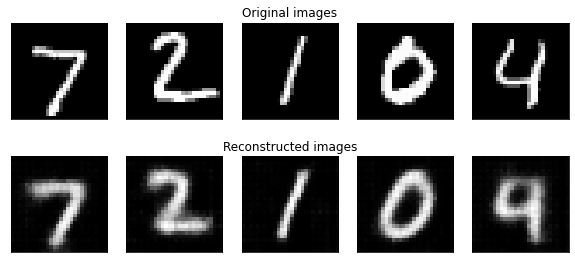

	 partial train loss (single batch): 9216.206055
	 partial train loss (single batch): 9398.366211
	 partial train loss (single batch): 9329.658203
	 partial train loss (single batch): 9741.426758
	 partial train loss (single batch): 9694.807617
	 partial train loss (single batch): 9334.580078
	 partial train loss (single batch): 9409.084961
	 partial train loss (single batch): 9858.356445
	 partial train loss (single batch): 9912.384766
	 partial train loss (single batch): 9603.771484
	 partial train loss (single batch): 10132.187500
	 partial train loss (single batch): 9422.513672
	 partial train loss (single batch): 9845.747070
	 partial train loss (single batch): 10090.267578
	 partial train loss (single batch): 9491.865234
	 partial train loss (single batch): 9781.233398
	 partial train loss (single batch): 9307.632812
	 partial train loss (single batch): 9590.226562
	 partial train loss (single batch): 9522.477539
	 partial train loss (single batch): 9577.359375
	 partial train lo

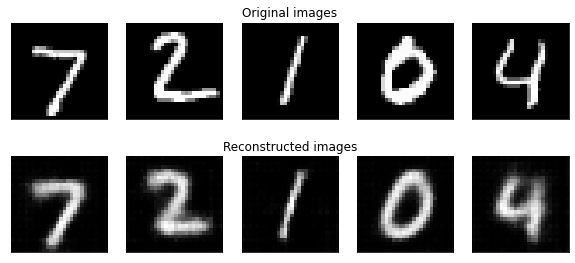

	 partial train loss (single batch): 9204.407227
	 partial train loss (single batch): 9395.826172
	 partial train loss (single batch): 9249.092773
	 partial train loss (single batch): 9688.807617
	 partial train loss (single batch): 9636.822266
	 partial train loss (single batch): 9340.917969
	 partial train loss (single batch): 9328.430664
	 partial train loss (single batch): 9832.011719
	 partial train loss (single batch): 9785.262695
	 partial train loss (single batch): 9592.718750
	 partial train loss (single batch): 10048.353516
	 partial train loss (single batch): 9346.751953
	 partial train loss (single batch): 9798.866211
	 partial train loss (single batch): 10049.675781
	 partial train loss (single batch): 9482.186523
	 partial train loss (single batch): 9666.539062
	 partial train loss (single batch): 9211.904297
	 partial train loss (single batch): 9554.074219
	 partial train loss (single batch): 9469.819336
	 partial train loss (single batch): 9599.685547
	 partial train lo

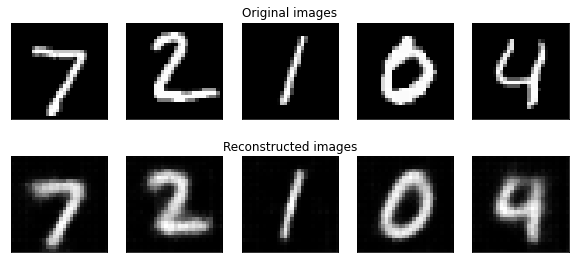

	 partial train loss (single batch): 9079.622070
	 partial train loss (single batch): 9354.369141
	 partial train loss (single batch): 9210.111328
	 partial train loss (single batch): 9681.904297
	 partial train loss (single batch): 9534.514648
	 partial train loss (single batch): 9190.808594
	 partial train loss (single batch): 9336.534180
	 partial train loss (single batch): 9757.977539
	 partial train loss (single batch): 9766.442383
	 partial train loss (single batch): 9570.361328
	 partial train loss (single batch): 10038.621094
	 partial train loss (single batch): 9355.249023
	 partial train loss (single batch): 9825.365234
	 partial train loss (single batch): 10114.242188
	 partial train loss (single batch): 9404.753906
	 partial train loss (single batch): 9698.221680
	 partial train loss (single batch): 9216.988281
	 partial train loss (single batch): 9541.317383
	 partial train loss (single batch): 9487.558594
	 partial train loss (single batch): 9533.526367
	 partial train lo

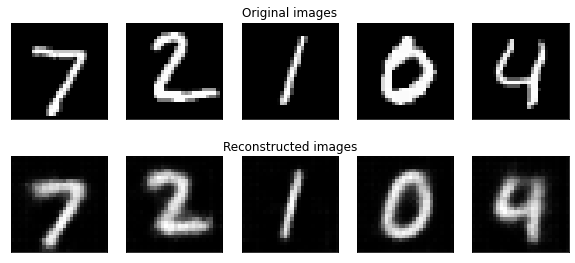

	 partial train loss (single batch): 9228.394531
	 partial train loss (single batch): 9478.481445
	 partial train loss (single batch): 9226.819336
	 partial train loss (single batch): 9641.267578
	 partial train loss (single batch): 9588.809570
	 partial train loss (single batch): 9205.974609
	 partial train loss (single batch): 9328.447266
	 partial train loss (single batch): 9792.122070
	 partial train loss (single batch): 9816.441406
	 partial train loss (single batch): 9519.435547
	 partial train loss (single batch): 9965.854492
	 partial train loss (single batch): 9307.484375
	 partial train loss (single batch): 9819.679688
	 partial train loss (single batch): 9980.885742
	 partial train loss (single batch): 9484.810547
	 partial train loss (single batch): 9741.733398
	 partial train loss (single batch): 9233.958008
	 partial train loss (single batch): 9513.131836
	 partial train loss (single batch): 9415.980469
	 partial train loss (single batch): 9524.971680
	 partial train loss

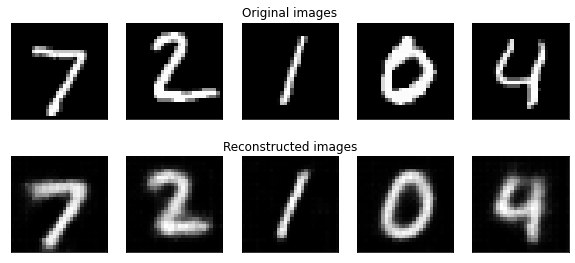

	 partial train loss (single batch): 9099.586914
	 partial train loss (single batch): 9293.230469
	 partial train loss (single batch): 9195.077148
	 partial train loss (single batch): 9578.150391
	 partial train loss (single batch): 9510.992188
	 partial train loss (single batch): 9130.814453
	 partial train loss (single batch): 9242.854492
	 partial train loss (single batch): 9823.660156
	 partial train loss (single batch): 9723.257812
	 partial train loss (single batch): 9448.543945
	 partial train loss (single batch): 9948.817383
	 partial train loss (single batch): 9292.214844
	 partial train loss (single batch): 9741.960938
	 partial train loss (single batch): 10017.686523
	 partial train loss (single batch): 9407.945312
	 partial train loss (single batch): 9591.990234
	 partial train loss (single batch): 9158.843750
	 partial train loss (single batch): 9496.371094
	 partial train loss (single batch): 9406.062500
	 partial train loss (single batch): 9378.805664
	 partial train los

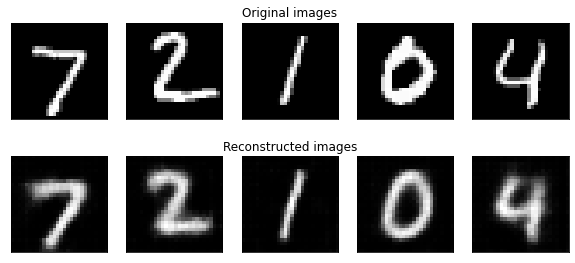

	 partial train loss (single batch): 9023.755859
	 partial train loss (single batch): 9263.961914
	 partial train loss (single batch): 9174.971680
	 partial train loss (single batch): 9547.584961
	 partial train loss (single batch): 9487.821289
	 partial train loss (single batch): 9085.356445
	 partial train loss (single batch): 9261.781250
	 partial train loss (single batch): 9718.645508
	 partial train loss (single batch): 9682.041016
	 partial train loss (single batch): 9448.059570
	 partial train loss (single batch): 9991.581055
	 partial train loss (single batch): 9222.716797
	 partial train loss (single batch): 9651.095703
	 partial train loss (single batch): 9963.807617
	 partial train loss (single batch): 9398.841797
	 partial train loss (single batch): 9650.559570
	 partial train loss (single batch): 9186.676758
	 partial train loss (single batch): 9521.065430
	 partial train loss (single batch): 9304.760742
	 partial train loss (single batch): 9511.500977
	 partial train loss

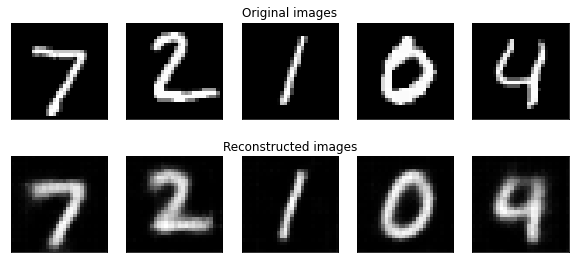

	 partial train loss (single batch): 9001.513672
	 partial train loss (single batch): 9153.912109
	 partial train loss (single batch): 9170.219727
	 partial train loss (single batch): 9514.664062
	 partial train loss (single batch): 9481.259766
	 partial train loss (single batch): 9099.713867
	 partial train loss (single batch): 9241.209961
	 partial train loss (single batch): 9617.703125
	 partial train loss (single batch): 9657.322266
	 partial train loss (single batch): 9505.139648
	 partial train loss (single batch): 9905.773438
	 partial train loss (single batch): 9226.001953
	 partial train loss (single batch): 9616.762695
	 partial train loss (single batch): 9855.520508
	 partial train loss (single batch): 9355.978516
	 partial train loss (single batch): 9553.718750
	 partial train loss (single batch): 9102.650391
	 partial train loss (single batch): 9520.491211
	 partial train loss (single batch): 9278.708984
	 partial train loss (single batch): 9401.499023
	 partial train loss

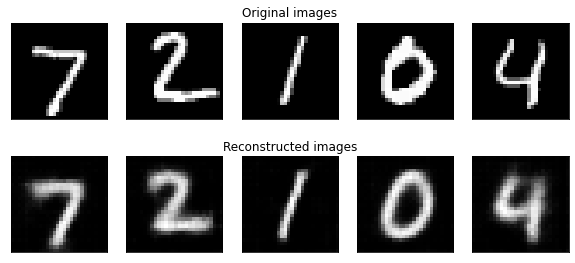

In [19]:
num_epochs = 20
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [20]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

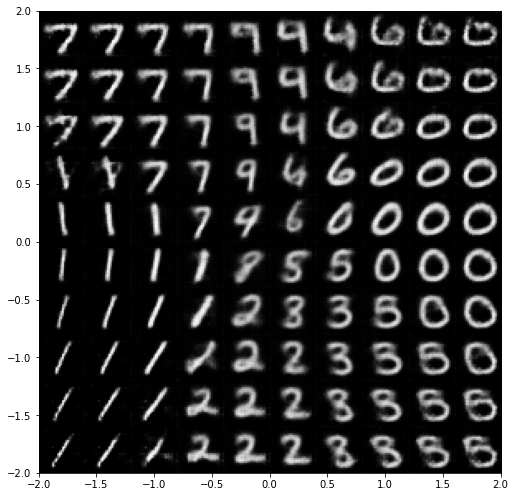

In [21]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [22]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:10<00:00, 913.58it/s]


In [23]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-0.972133,0.665345,7
1,0.123935,-2.388716,2
2,-1.282104,-0.726584,1
3,0.861146,-0.113400,0
4,0.102920,0.628034,4
...,...,...,...
9995,-0.053518,-0.868140,2
9996,0.553864,-0.624344,3
9997,-0.421178,0.257943,4
9998,0.072754,-0.094022,5


In [24]:
from sklearn.manifold import TSNE
import plotly.express as px

In [25]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [26]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

D:\anaconda\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

D:\anaconda\envs\py38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [27]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()